In [6]:
# Importazione delle librerie necessarie
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
# Caricamento del dataset
df = pd.read_csv('EnergyConsumption.csv')

# Visualizzazione delle prime righe
df.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [8]:
df.info

<bound method DataFrame.info of                    Datetime   AEP_MW
0       2004-12-31 01:00:00  13478.0
1       2004-12-31 02:00:00  12865.0
2       2004-12-31 03:00:00  12577.0
3       2004-12-31 04:00:00  12517.0
4       2004-12-31 05:00:00  12670.0
...                     ...      ...
121268  2018-01-01 20:00:00  21089.0
121269  2018-01-01 21:00:00  20999.0
121270  2018-01-01 22:00:00  20820.0
121271  2018-01-01 23:00:00  20415.0
121272  2018-01-02 00:00:00  19993.0

[121273 rows x 2 columns]>

# 1a Parte: Cleaning e Resample dei Dati

Convertiamo la data da stringa in DateTime

In [9]:
df['Datetime'] = pd.to_datetime(df['Datetime'], format="%Y-%m-%d %H:%M:%S")

In [10]:
# Mettiamo il DateTame come indice dell'asse X e mi assicuro di ordinarli dal più vecchio al più recente
df = df.set_index('Datetime')
df = df.sort_index()

# Verifica
print(f"Range temporale: dal {df.index.min()} al {df.index.max()}")
df.head()

Range temporale: dal 2004-10-01 01:00:00 al 2018-08-03 00:00:00


,AEP_MW
Datetime,
2004-10-01 01:00:00,12379.0
2004-10-01 02:00:00,11935.0
2004-10-01 03:00:00,11692.0
2004-10-01 04:00:00,11597.0
2004-10-01 05:00:00,11681.0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 121273 entries, 2004-10-01 01:00:00 to 2018-08-03 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   AEP_MW  121273 non-null  float64
dtypes: float64(1)
memory usage: 1.9 MB


### Rimozione di duplicati
I duplicati sono frequenti a causa del cambio dell'ora legale o errori dei sensori.
Manteniamo la prima rilevazione per garantire l'unicità dell'indice temporale.

In [12]:
# Verifico se ci sono dei duplicati
duplicati = df.index.duplicated().sum()
print(f"Numero di orari duplicati trovati: {duplicati}")

# Rimozione Duplicati
# Mantengo solo la prima occorrenza con 'first'.
df = df[~df.index.duplicated(keep='first')]

print("Duplicati rimossi.")
print("Duplicati attuali:", df.index.duplicated().sum())

Numero di orari duplicati trovati: 4
Duplicati rimossi.
Duplicati attuali: 0


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 121269 entries, 2004-10-01 01:00:00 to 2018-08-03 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   AEP_MW  121269 non-null  float64
dtypes: float64(1)
memory usage: 5.9 MB


### Cerchiamo se ci sono valori mancanti

I valori mancanti (NaN) possono derivare da blackout del sensore o errori di trasmissione. Non possiamo accettare valori vuoti in input per la parte di Machine Learning. Verifichiamo la loro presenza per decidere se imputarli (stimarli) o rimuovere le righe corrotte."

In [14]:
# Contiamo i valori mancanti (NaN)
missing = df.isna().sum()
print("Valori mancanti per colonna:\n", missing)

# Se ce ne sono pochi, li possiamo eliminare (dropna) o riempire (fillna)
# In questo dataset, se sono pochi, li eliminiamo per pulizia.
if missing['AEP_MW'] > 0:
    df = df.dropna()
    print("Valori mancanti eliminati.")
else:
    print("Il dataset è completo, nessuna azione necessaria.")

Valori mancanti per colonna:
 AEP_MW    0
dtype: int64
Il dataset è completo, nessuna azione necessaria.


## Fine 1a Parte: Cleaning e Resample dei Dati
Ora abbiamo un Dataset Temporale, Ordinato, Senza Doppioni e Senza Mancanze.

# 2a Parte: EDA (Exploratory Data Analysis).
Analizziamo come si comporta il consumo energetico nel tempo

In [15]:
# Creo nuove variabili: Feature Engineering
# Estraggo le informazioni dall'indice temporale per poterle analizzare separatamente.
df['Hour'] = df.index.hour           # Ora del giorno (0-23)
df['Month'] = df.index.month         # Mese dell'anno (1-12)
df['Year'] = df.index.year           # Anno
df['DayOfWeek'] = df.index.dayofweek # Giorno della settimana (0=Lun, 6=Dom)

L'algoritmo non sa che il mese 8 è 'Agosto'.

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 121269 entries, 2004-10-01 01:00:00 to 2018-08-03 00:00:00
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   AEP_MW     121269 non-null  float64
 1   Hour       121269 non-null  int32  
 2   Month      121269 non-null  int32  
 3   Year       121269 non-null  int32  
 4   DayOfWeek  121269 non-null  int32  
dtypes: float64(1), int32(4)
memory usage: 7.7 MB


In [17]:
# Faccio un Resampling
# I dati orari sono oltre 120.000 righe
# Calcolo la media mensile per vedere il trend in modo più pulito.
df_monthly = df['AEP_MW'].resample('ME').mean()

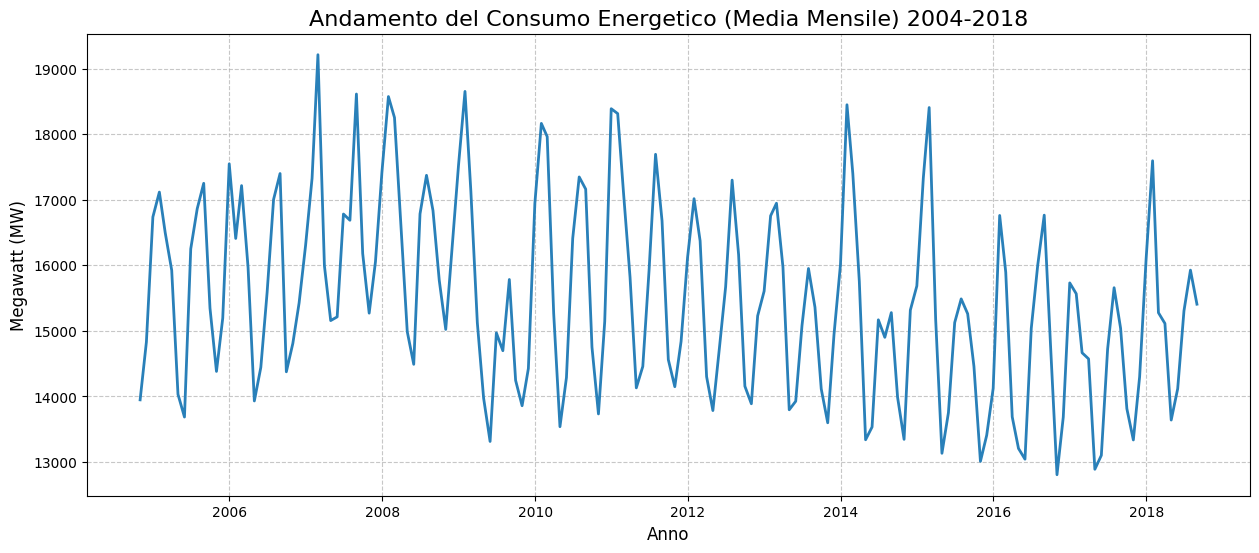

In [18]:
# Visualizzazione grafica dell'Intero Periodo
plt.figure(figsize=(15, 6))
sns.lineplot(data=df_monthly, color='#2980b9', linewidth=2)

plt.title('Andamento del Consumo Energetico (Media Mensile) 2004-2018', fontsize=16)
plt.ylabel('Megawatt (MW)', fontsize=12)
plt.xlabel('Anno', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

Notiamo dal grafico che c'è un pattern regolare e ripetitivo. Il consumo energetico non è casuale ma stagionale. Ogni anni abbiamo due picchi distinti: estivo e invernale. Il primo è dovuto al grande utilizzo di aria condizionata, il secondo dal riscaldamento e dall'illuminazione dovuto dalle giornate corte.

## Scomponiamo il grafico
Rappresenteremo 3 grafici: Trend, Stagionalità e Rumore

1. Trend: 
È la direzione generale del consumo nel lungo periodo, pulita dalle variazioni annuali. 
2. Stagionalità: 
Evidenzia i pattern ricorrenti ogni anno, isolando l'impatto specifico di ogni stagione (es. quanto l'estate "consuma" rispetto alla Primavera)
3. Rumore: 
Presenta le anomalie imprevedibili dai calcoli matematici.


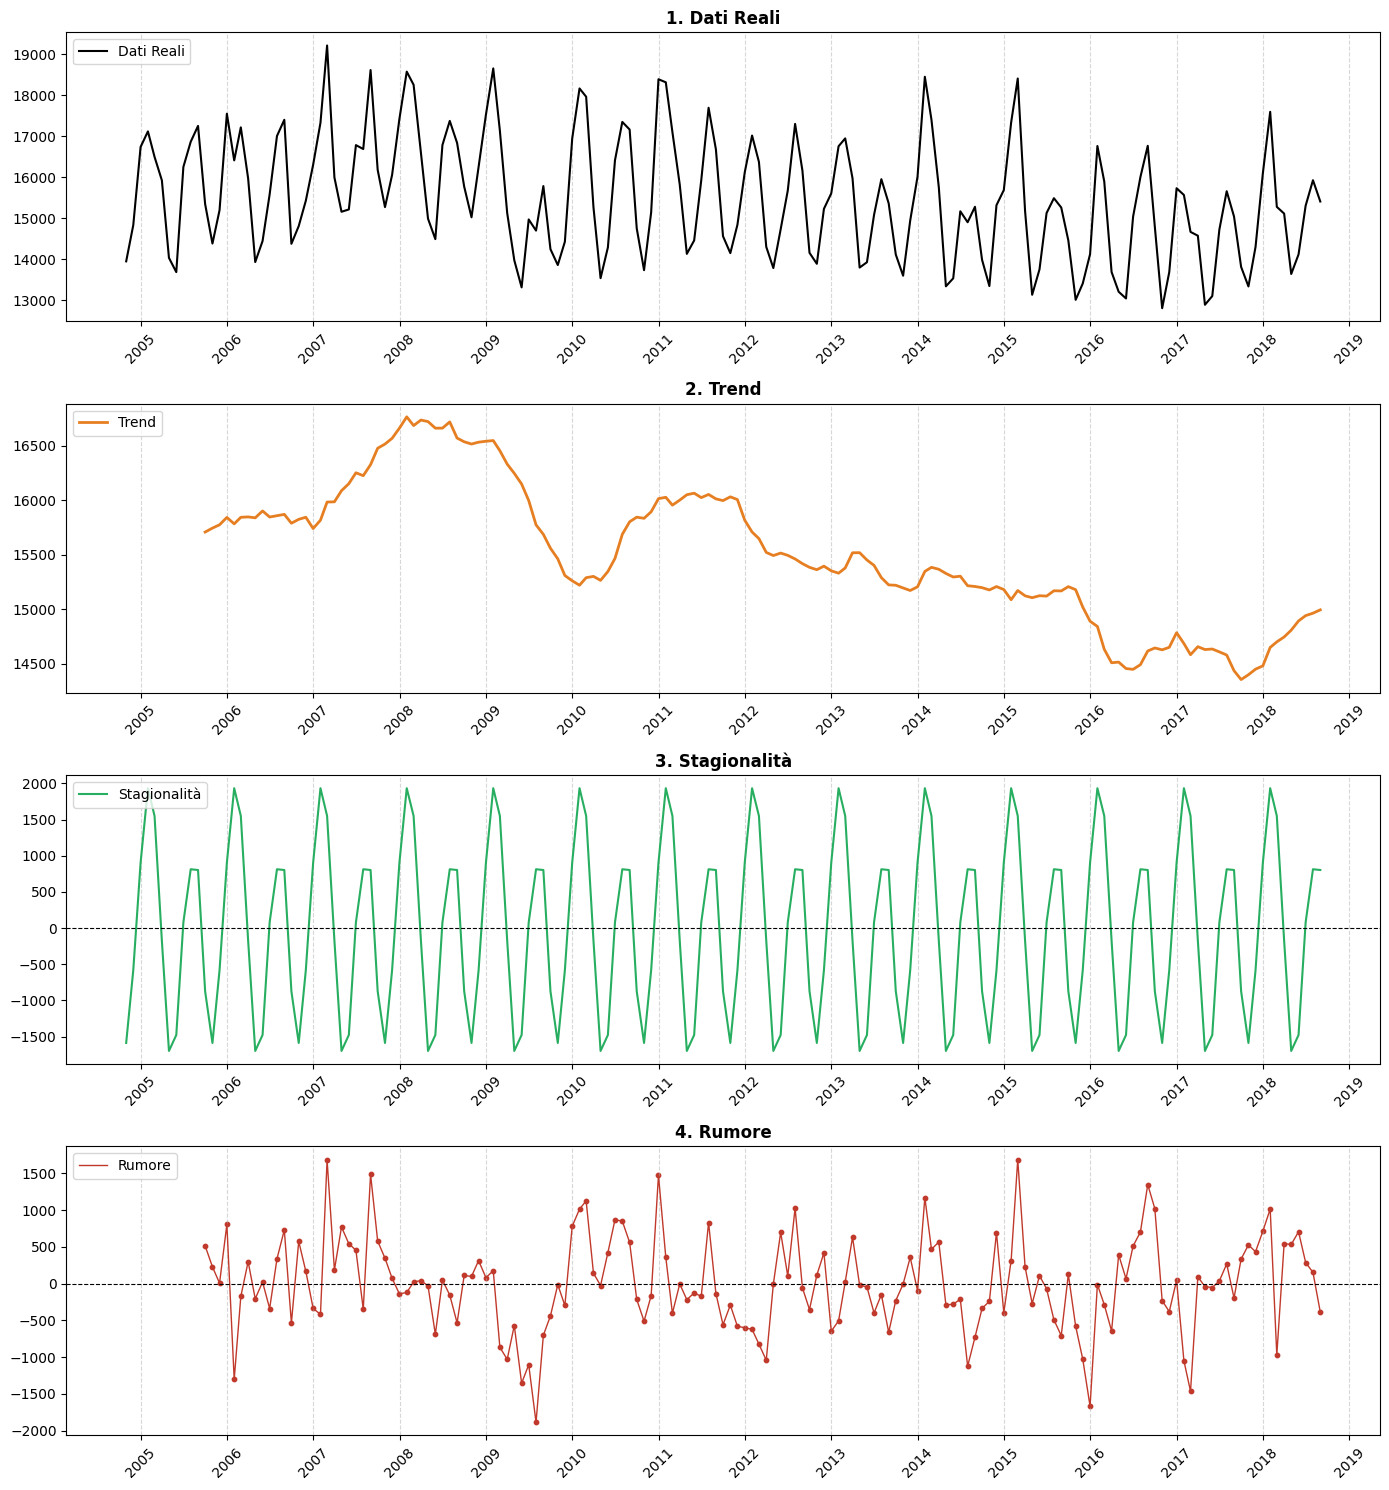

In [ ]:
import matplotlib.dates as mdates 
# Calcolo il TREND
# Prendo 12 mesi alla volta (un anno) e ci faccio la media
trend = df_monthly.rolling(window=12).mean()
# --------------------------------------------------------------------------

# Calcolo la STAGIONALITÀ
# Togliamo il trend dai dati originali.
# Non ci interessa il trend per calcolare la stagionalità
detrended = df_monthly - trend

# Calcolo la media per ogni mese
monthly_seasonality = detrended.groupby(detrended.index.month).mean()

# Metto la stagionalità media su tutto il nostro asse temporale
seasonality = df_monthly.index.map(lambda d: monthly_seasonality[d.month])

# Trasformo in Series pandas per comodità di calcolo
seasonality = pd.Series(seasonality, index=df_monthly.index)
# --------------------------------------------------------------------------

# 3. Calcolo il RUMORE
# Dato Reale - Trend - Stagionalità
residuo = df_monthly - trend - seasonality

# --------------------------------------------------------------------------

# GRAFICI DELLA SCOMPOSIZIONE
# Creo una figura con 4 sottografi
fig, axes = plt.subplots(4, 1, figsize=(14, 15), sharex=True)

# Grafico 1: Dati Reali
axes[0].plot(df_monthly, label='Dati Reali', color='black')
axes[0].set_title('1. Dati Reali', fontweight='bold')
axes[0].legend(loc='upper left')

# Grafico 2: Trend
axes[1].plot(trend, label='Trend', color='#e67e22', linewidth=2)
axes[1].set_title('2. Trend', fontweight='bold')
axes[1].legend(loc='upper left')

# Grafico 3: Stagionalità
axes[2].plot(seasonality, label='Stagionalità', color='#27ae60')
axes[2].axhline(0, color='black', linestyle='--', linewidth=0.8)
axes[2].set_title('3. Stagionalità', fontweight='bold')
axes[2].legend(loc='upper left')

# Grafico 4: Rumore
axes[3].plot(residuo, label='Rumore', color='#c0392b', linewidth=1)
axes[3].scatter(residuo.index, residuo, color='#c0392b', s=10)
axes[3].axhline(0, color='black', linestyle='--', linewidth=0.8)
axes[3].set_title('4. Rumore', fontweight='bold')
axes[3].legend(loc='upper left')

# Gestione delle date sull'asse X per tutti i grafici
for ax in axes:
    # Impostiamo un "tick" per ogni anno
    ax.xaxis.set_major_locator(mdates.YearLocator(1))
    
    # Formattiamo la data scrivendo solo l'anno
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    
    # Forziamo la visualizzazione delle etichette anche nei grafici superiori
    ax.tick_params(axis='x', which='both', labelbottom=True, rotation=45)
    
    #  Aggiungiamo una griglia verticale per allineare tutto visivamente
    ax.grid(True, which='major', axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

Il primo grafico è troppo confuso. Con la scomposizione abbiamo dimostrato che il consumo è guidato da una Stagionalità fortissima, ma che il Trend è in leggera diminuzione grazie all'efficienza energetica, tranne per eventi casuali che sono visibili nel Rumore.

Notiamo anche graficamente, che periodo estivo e quello invernale sono quelli che consumano di più. Cerchiamo ora di capire quali sono mediamente gli orari di picco, cosi da evitare blackout negli orari di picco.

### Inverno vs Estate: Giornata Tipo a confronto.

In [36]:
# Definiamo le stagioni
def get_season(month):
    if month in [6, 7, 8]:
        return 'Estate'
    elif month in [12, 1, 2]:
        return 'Inverno'
    else:
        return 'Altro'

df['Season'] = df['Month'].apply(get_season)

In [38]:
df.head()

,AEP_MW,Hour,Month,Year,DayOfWeek,Season
Datetime,,,,,,
2004-10-01 01:00:00,12379.0,1,10,2004,4,Altro
2004-10-01 02:00:00,11935.0,2,10,2004,4,Altro
2004-10-01 03:00:00,11692.0,3,10,2004,4,Altro
2004-10-01 04:00:00,11597.0,4,10,2004,4,Altro
2004-10-01 05:00:00,11681.0,5,10,2004,4,Altro


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 121269 entries, 2004-10-01 01:00:00 to 2018-08-03 00:00:00
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   AEP_MW     121269 non-null  float64
 1   Hour       121269 non-null  int32  
 2   Month      121269 non-null  int32  
 3   Year       121269 non-null  int32  
 4   DayOfWeek  121269 non-null  int32  
 5   Season     121269 non-null  object 
dtypes: float64(1), int32(4), object(1)
memory usage: 8.7+ MB


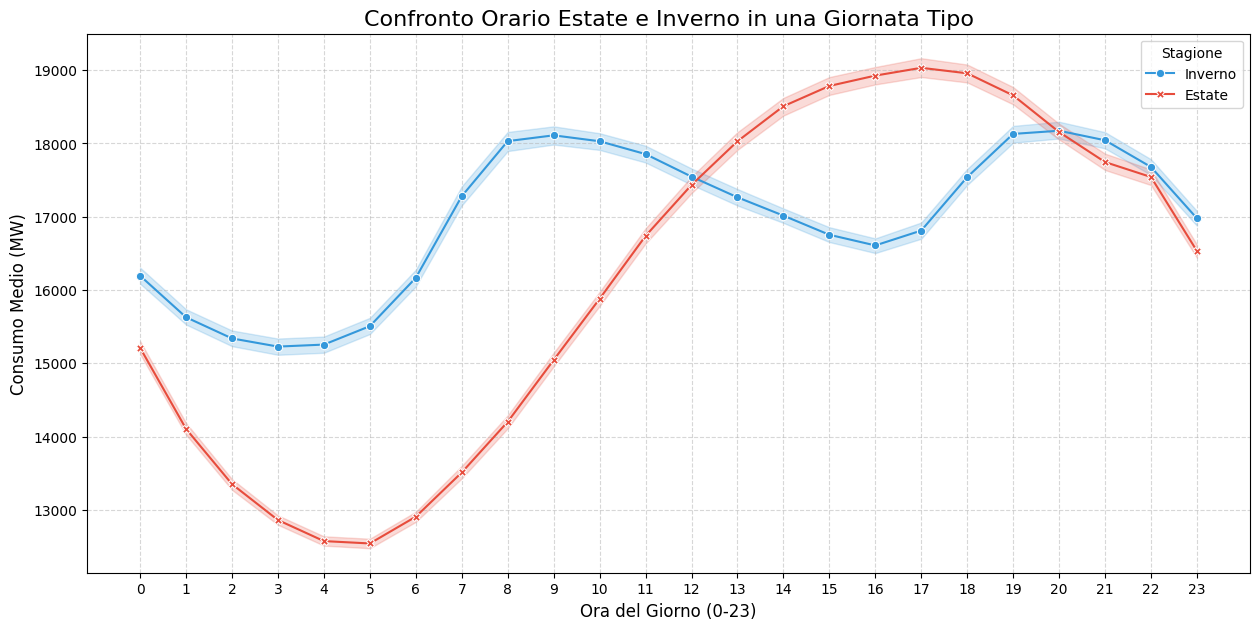

In [40]:
# Creiamo il grafico a confronto
plt.figure(figsize=(15, 7))

# Filtriamo solo Estate e Inverno
subset = df[df['Season'].isin(['Estate', 'Inverno'])]

# dizionario per i colori personalizzati
colori_personalizzati = {'Estate': '#e74c3c', 'Inverno': '#3498db'}

sns.lineplot(data=subset, x='Hour', y='AEP_MW', hue='Season', style='Season', markers=True, dashes=False, palette=colori_personalizzati) # Passiamo il dizionario qui

plt.title('Confronto Orario Estate e Inverno in una Giornata Tipo', fontsize=16)
plt.ylabel('Consumo Medio (MW)', fontsize=12)
plt.xlabel('Ora del Giorno (0-23)', fontsize=12)
plt.xticks(range(0, 24))
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Stagione')
plt.show()

Il grafico mette a confronto come cambia la domanda di energia a seconda della stagione.
Abbiamo due comportamenti opposti:

#### 1. Estate (Linea Rossa)
* **Forma:** Una singola gobba centrale.
* **Il Comportamento:**
    * Di notte il consumo è minimo.
    * Dalle **12:00 alle 18:00** il consumo esplode verso l'alto, raggiungendo il picco massimo assoluto di tutto l'anno.
* La Causa è l'Aria Condizionata. Segue l'andamento del calore solare.

#### 2. Inverno (Linea Blu)
* **Forma:** Due picchi distinti con un avvallamento centrale.
* **Il Comportamento:**
    * **Picco 1 (Mattina, 07:00-09:00):** Il risveglio della popolazione. Si accendono luci, riscaldamento e inizia l'attività industriale.
    * **Picco 2 (Sera, 18:00-21:00):** Il rientro a casa. Fa buio presto (illuminazione accesa), si cucina, si usa la TV e si alza il riscaldamento.
    * **La Valle (10:00-16:00):** Nel cuore della giornata il consumo scende.
        * Le case sono vuote e il riscaldamento solare fornisce un po' di calore naturale.

## Fine 2a Parte: EDA (Exploratory Data Analysis).

## Inizio 3a Parte: Clustering (Segmentazione delle Giornate)

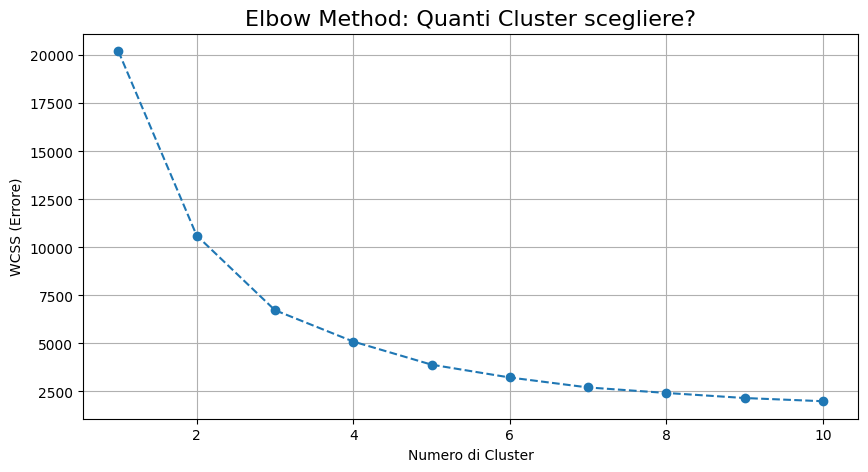

In [41]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 1. Preparazione dei Dati per il Clustering
# Dobbiamo riassumere ogni giornata in poche caratteristiche chiave.
# Per ogni giorno calcoliamo: Media consumo, Picco Massimo, Minimo e Deviazione Standard (quanto oscilla).
daily_data = df['AEP_MW'].resample('D').agg(['mean', 'max', 'min', 'std'])
daily_data = daily_data.dropna() # Rimuoviamo eventuali giorni incompleti

# 2. Scaling (Fondamentale per il Clustering)
# K-Means calcola le distanze. Se non scaliamo i dati, i numeri grandi "vincono" su quelli piccoli.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(daily_data)

# 3. Elbow Method (Metodo del Gomito)
# Serve a decidere QUANTI gruppi (Cluster) creare.
wcss = [] # Within-Cluster Sum of Square
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Grafico del Gomito
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method: Quanti Cluster scegliere?', fontsize=16)
plt.xlabel('Numero di Cluster')
plt.ylabel('WCSS (Errore)')
plt.grid(True)
plt.show()